In [8]:
import json
import numpy as np
import pandas as pd
import psycopg2
from bertopic import BERTopic
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from IPython.display import display
import matplotlib as mpl
from hdbscan import HDBSCAN
from collections import Counter

In [9]:
def ler_dados(conn) -> pd.DataFrame:
    """
    Lê ementa, descrição/questões, envolve_mei, vetores e a cor do cluster do banco.
    Concatena descricao_caso + questoes_em_discussao em 'texto_descricao_caso',
    e converte os vetores para np.ndarray(float32).

    Retorna um DataFrame com:
      - id
      - envolve_mei
      - ementa_completa
      - texto_descricao_caso
      - vetor_ementa_reduzido_extracao_topico
      - vetor_ementa_reduzido_plotagem
      - vetor_descricao_questoes_testes_extracao
      - vetor_descricao_questoes_teste_plotagem
      - cor_cluster   (string, ex.: "#1f77b4")
    """
    def _parse_vector_cell(cell):
        if cell is None:
            return None
        if isinstance(cell, (bytes, memoryview)):
            cell = bytes(cell).decode("utf-8", errors="ignore")
        if isinstance(cell, (list, tuple, np.ndarray)):
            return np.asarray(cell, dtype=np.float32)
        if isinstance(cell, str):
            s = cell.strip()
            try:
                return np.asarray(json.loads(s), dtype=np.float32)
            except Exception:
                s = s.strip("[](){}")
                if not s:
                    return None
                return np.asarray([float(x) for x in s.split(",")], dtype=np.float32)
        try:
            return np.asarray(cell, dtype=np.float32)
        except Exception:
            return None

    def _normalize_envolve_mei(v):
        if v is None:
            return None
        if isinstance(v, bool):
            return int(v)
        try:
            return int(v)
        except Exception:
            s = str(v).strip().lower()
            if s in {"true", "t", "sim", "1"}:
                return 1
            if s in {"false", "f", "não", "nao", "0"}:
                return 0
            return v

    with conn.cursor() as cur:
        cur.execute("""
            SELECT
                id,
                ementa_completa,
                descricao_caso,
                questoes_em_discussao,
                envolve_mei,
                vetor_ementa_reduzido_extracao_topico,
                vetor_ementa_reduzido_plotagem,
                vetor_descricao_questoes_testes_extracao,
                vetor_descricao_questoes_teste_plotagem,
                cor_cluster
            FROM PROCESSOS
            WHERE descricao_caso IS NOT NULL
              AND questoes_em_discussao IS NOT NULL
              AND not (
    CAST(split_part(trim(both '[]' from vetor_descricao_questoes_teste_plotagem::text), ',', 1) AS float) > 7
    AND CAST(split_part(trim(both '[]' from vetor_descricao_questoes_teste_plotagem::text), ',', 2) AS float) > 18
) 
        """)
        rows = cur.fetchall()

    ids, envolve_mei_list, ementas = [], [], []
    textos_desc = []
    v_ementa_red_extr, v_ementa_red_plot = [], []
    v_descquest_extr, v_descquest_plot = [], []
    cores = []

    for (id_,
         ementa_completa,
         descricao_caso,
         questoes_em_discussao,
         envolve_mei,
         vec_ementa_extr,
         vec_ementa_plot,
         vec_descquest_extr,
         vec_descquest_plot,
         cor_cluster) in rows:

        ids.append(id_)
        envolve_mei_list.append(_normalize_envolve_mei(envolve_mei))
        ementas.append(ementa_completa)

        desc = (descricao_caso or "").strip()
        ques = (questoes_em_discussao or "").strip()
        texto_concat = f"{desc}\n\n{ques}" if (desc and ques) else (desc or ques)
        textos_desc.append(texto_concat if texto_concat else None)

        v_ementa_red_extr.append(_parse_vector_cell(vec_ementa_extr))
        v_ementa_red_plot.append(_parse_vector_cell(vec_ementa_plot))
        v_descquest_extr.append(_parse_vector_cell(vec_descquest_extr))
        v_descquest_plot.append(_parse_vector_cell(vec_descquest_plot))
        cores.append((cor_cluster or "").strip() if cor_cluster is not None else None)

    df = pd.DataFrame({
        "id": ids,
        "envolve_mei": envolve_mei_list,
        "ementa_completa": ementas,
        "texto_descricao_caso": textos_desc,
        "vetor_ementa_reduzido_extracao_topico": v_ementa_red_extr,
        "vetor_ementa_reduzido_plotagem": v_ementa_red_plot,
        "vetor_descricao_questoes_testes_extracao": v_descquest_extr,
        "vetor_descricao_questoes_teste_plotagem": v_descquest_plot,
        "cor_cluster": cores
    })
    return df


In [10]:
conn = psycopg2.connect(
    host="localhost",
    database="PROCESSOS",
    user="postgres",
    password="admin",
)

df = ler_dados(conn)
df.head()

id  envolve_mei                                    ementa_completa  \
0  46337            1  TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO COM...   
1  40513            1  PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...   
2  45639            1  TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO COM...   
3  55562            1  PODER JUDICIÁRIO DO ESTADO DE MINAS GERAISJust...   
4  58108            1  PODER JUDICIÁRIO DO ESTADO DE MINAS GERAISJust...   

                                texto_descricao_caso  \
0  Um microempreendedor individual (MEI) entrou c...   
1  Um microempreendedor individual (MEI) entrou c...   
2  Uma pessoa entrou com uma ação de indenização ...   
3  Um indivíduo chamado Lucas dos Santos Lima ent...   
4  Um MEI que utiliza seu veículo para transporte...   

               vetor_ementa_reduzido_extracao_topico  \
0  [11.36518, 6.4579263, 3.5405257, 6.517104, 4.8...   
1  [10.212991, 5.883346, 4.8443904, 5.969126, 4.8...   
2  [11.447918, 6.617456, 3.4511256, 6.406045, 4.6...   
3  [11.263959, 5.908598, 3.7389414, 6.30883, 4.83...   
4  [11.133461, 5.912537, 3.6739647, 6.621857, 5.1...   

  vetor_ementa_reduzido_plotagem  \
0          [5.3837495, 8.196298]   
1         [4.9081855, 4.9511786]   
2           [5.1466846, 8.43949]   
3          [5.051889, 7.3369436]   
4          [5.765535, 7.6938467]   

            vetor_descricao_questoes_testes_extracao  \
0  [8.651777, 2.1856384, 8.463054, 5.5298247, 5.2...   
1  [8.643773, 2.0116758, 8.372978, 5.675199, 5.36...   
2  [8.665745, 2.2172508, 8.467156, 5.5380855, 5.3...   
3  [8.686547, 2.1164887, 8.513468, 5.5109777, 5.1...   
4  [8.565893, 2.1460066, 8.493598, 5.5618424, 5.2...   

  vetor_descricao_questoes_teste_plotagem cor_cluster  
0                   [4.144794, 4.7422557]     #19B28A  
1                      [4.165736, 5.0108]     #19B28A  
2                   [4.128393, 4.8085885]     #19B28A  
3                    [3.964392, 4.811271]     #19B28A  
4                     [4.180053, 4.98975]     #19B28A

In [11]:
class _IdentityDim:
    def fit(self, X, y=None): return self
    def transform(self, X): return X

def executar_bertopic(
    corpus,
    embeddings,            # pode ser Series/lista de np.ndarrays ou matriz (N, D)
    embeddings_plotagem,   # pode ser Series/lista de np.ndarrays 2D ou matriz (N, 2+)
    top_n_topics=20,
    n_words=10,
    language="portuguese",
    titulo=None,
    plot_sample=None,
    anotar_centroides=False,
    mostrar_legenda=False,
    cor_por_processo=None,   # lista/Series com a cor por processo (ex.: "#1f77b4")
):
    """
    Executa BERTopic com embeddings prontos e plota clusters usando embeddings_plotagem (2D).
    - Aceita pandas Series e faz o empilhamento (vstack) interno.
    - Filtra linhas inválidas (texto vazio, vetores ausentes).
    - Cores: usa a cor majoritária por tópico com base em 'cor_por_processo'.
    """

    # --- Converte inputs para Series para facilitar filtragem/alinhamento ---
    if not isinstance(corpus, (pd.Series, list)):
        raise ValueError("Passe 'corpus' como pandas Series ou lista de strings.")
    corpus = pd.Series(corpus, dtype="object")

    emb_col  = pd.Series(embeddings, dtype="object")
    plot_col = pd.Series(embeddings_plotagem, dtype="object")

    # --- Máscaras de validade ---
    mask_texto = corpus.fillna("").str.strip().ne("")

    def _ok_vec(v, min_len=1):
        return isinstance(v, (np.ndarray, list, tuple)) and len(v) >= min_len

    mask_emb  = emb_col.apply(lambda v: _ok_vec(v, 1))
    mask_plot = plot_col.apply(lambda v: _ok_vec(v, 2) and (np.asarray(v).shape[-1] >= 2))

    mask = mask_texto & mask_emb & mask_plot
    if mask.sum() == 0:
        raise ValueError("Nenhuma linha válida após filtrar texto/embeddings/plotagem.")
    if mask.sum() < len(corpus):
        print(f"ℹ️ Removidas {len(corpus) - mask.sum()} linhas inválidas (texto vazio/vetores ausentes).")

    corpus_ok = corpus[mask].tolist()

    # --- Alinha cores por processo aos registros válidos ---
    if cor_por_processo is not None:
        cor_series = pd.Series(cor_por_processo, dtype="object")
        cor_ok = cor_series[mask].astype(str).str.strip().replace({"": None}).tolist()
    else:
        cor_ok = [None] * len(corpus_ok)

    # Empilha embeddings (N, D) e plotagem (N, 2+)
    X = np.vstack([np.asarray(v, dtype=np.float32) for v in emb_col[mask]])
    Xp = np.vstack([np.asarray(v, dtype=np.float32) for v in plot_col[mask]])

    if Xp.shape[1] < 2:
        raise ValueError("embeddings_plotagem precisa ter pelo menos 2 dimensões.")

    # --- Cores categóricas por tópico (ruído em cinza) ---
    def _topic_colors(labels):
        labels = np.asarray(labels)
        n = len(labels)
        cores = np.full(n, '#BFBFBF', dtype=object)  # cinza para ruído
        topicos = [t for t in np.unique(labels) if t != -1]

        cmaps = [mpl.cm.get_cmap('tab20'), mpl.cm.get_cmap('tab20b'), mpl.cm.get_cmap('tab20c')]
        paleta = []
        for cmap in cmaps:
            paleta.extend([mpl.colors.to_hex(cmap(i)) for i in range(cmap.N)])
        if len(topicos) > len(paleta):
            extra = len(topicos) - len(paleta)
            hsv_extra = [mpl.colors.hsv_to_rgb((h, 0.65, 0.95)) for h in np.linspace(0, 1, extra, endpoint=False)]
            paleta.extend([mpl.colors.to_hex(c) for c in hsv_extra])

        for i, t in enumerate(topicos):
            cores[labels == t] = paleta[i]
        return cores, {t: paleta[i] for i, t in enumerate(topicos)}

    # --- BERTopic sem UMAP interno (não reduz de novo) ---
    try:
        dim_model = BaseDimensionalityReduction()   # oficial (não faz nada)
    except Exception:
        dim_model = _IdentityDim()                  # fallback compatível

    topic_model = BERTopic(
        verbose=True,
        language=language,
        umap_model=dim_model,          # NÃO reduz dimensionalidade novamente
        calculate_probabilities=False,
    )
    topics, probabilities = topic_model.fit_transform(corpus_ok, X)

    labels = np.asarray(topics)
    n_ruido = int(np.sum(labels == -1))
    n_topicos = len(np.unique(labels[labels != -1]))
    print(f"\n🔢 Tópicos (sem ruído): {n_topicos}")
    print(f"🔸 Documentos como ruído (-1): {n_ruido}")

    # --- Silhouette (sem ruído) no espaço de plotagem (2D) ---
    sil = None
    try:
        mask_cl = labels != -1
        if np.sum(mask_cl) > 2 and len(np.unique(labels[mask_cl])) >= 2:
            sil = silhouette_score(Xp[mask_cl, :2], labels[mask_cl], metric="euclidean")
            print(f"✅ Silhouette (sem ruído, no espaço de plotagem): {sil:.4f}")
        else:
            print("ℹ️ Silhouette não calculada (clusters insuficientes sem ruído).")
    except Exception as e:
        print(f"ℹ️ Silhouette não pôde ser calculada: {e}")

    # --- Info e listagem rápida ---
    info = topic_model.get_topic_info()
    print("\n📊 get_topic_info() (topo):")
    display(info.head(20))

    print("\n🗂️ Tópicos (palavras mais representativas):")
    info_valid = info[info["Topic"] != -1].sort_values("Count", ascending=False)
    for _, row in info_valid.head(top_n_topics).iterrows():
        tid = int(row["Topic"])
        palavras = [w for (w, _s) in topic_model.get_topic(tid)[:n_words]]
        print(f"  • Tópico {tid:>3} (Count={int(row['Count'])}): {', '.join(palavras)}")

    # --- Scatter 2D estilo "bolhas" (todos os pontos; sem halo/centróide/legenda) ---
    cores_full, mapa_topico_cor = _topic_colors(labels)

    # DataFrame para apurar cor majoritária por tópico
    dfp = pd.DataFrame({
        "x": Xp[:, 0],
        "y": Xp[:, 1],
        "topic": labels,
        "cor_proc": cor_ok
    })

    from collections import Counter
    topic_color_major = {}
    for t in np.unique(labels):
        if t == -1:
            continue
        cores_validas = [c for c in dfp.loc[dfp["topic"] == t, "cor_proc"].tolist() if c]
        if cores_validas:
            topic_color_major[t] = Counter(cores_validas).most_common(1)[0][0]

    # Fallback para paleta se um tópico não tiver cor majoritária válida
    lut = {t: topic_color_major.get(t, mapa_topico_cor.get(t, "#BFBFBF"))
           for t in np.unique(labels) if t != -1}

    mask_ruido   = (labels == -1)
    mask_cluster = ~mask_ruido

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_box_aspect(1)

    # ruído (fundo, cinza) — desabilitado, reabilite se quiser ver o ruído
    # if mask_ruido.any():
    #     ax.scatter(Xp[mask_ruido, 0], Xp[mask_ruido, 1],
    #                s=20, alpha=0.25, c="#BFBFBF", linewidths=0, zorder=1)

    # clusters (cores por tópico, cor majoritária)
    for t, cor in lut.items():
        m = (labels == t)
        if np.any(m):
            ax.scatter(Xp[m, 0], Xp[m, 1],
                       s=20, alpha=0.7, c=cor, linewidths=0, zorder=2)

    ttl = titulo or "Tópicos (Gráfico de bolhas)"
    ax.set_title(ttl, fontsize=13)
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.grid(False)
    ax.set_aspect('equal', adjustable='datalim')
    plt.tight_layout()
    plt.show()

    # --- Gráficos interativos do BERTopic ---
    print("\n📈 visualize_barchart()")
    fig_bar = topic_model.visualize_barchart(top_n_topics=top_n_topics, n_words=n_words)
    fig_bar.show()

    print("\n🌳 visualize_hierarchy()")
    fig_hier = topic_model.visualize_hierarchy()
    fig_hier.show()

    print("\n🌳 Cor por tópico")
    fig_hier = topic_model.visualize_hierarchy()
    fig_hier.show()
    return {
        "topic_model": topic_model,
        "topics": topics,
        "probabilities": probabilities,
        "topic_info": info,
        "silhouette": sil,
        "mask_utilizada": mask.values,           # útil para mapear ao DF original
        "cor_major_por_topico": topic_color_major,  # << cor observada (moda) por tópico
        "cor_plot_por_topico": lut,                 # << cor usada no plot por tópico (com fallback)
    }


🔎 EXPERIMENTO 1: 53240 registros


2025-10-20 13:28:50,256 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-20 13:28:50,258 - BERTopic - Dimensionality - Completed ✓
2025-10-20 13:28:50,266 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-20 13:29:03,385 - BERTopic - Cluster - Completed ✓
2025-10-20 13:29:03,437 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-20 13:33:35,909 - BERTopic - Representation - Completed ✓



🔢 Tópicos (sem ruído): 529
🔸 Documentos como ruído (-1): 22516
✅ Silhouette (sem ruído, no espaço de plotagem): 0.2452

📊 get_topic_info() (topo):


Topic  Count                                               Name  \
0      -1  22516                            -1_reclamante_que_da_de   
1       0   1257      0_ementaapelação_ementaagravo_provido_mantida   
2       1    634  1_contribuições_complementação_contribuição_un...   
3       2    536                 2_reclamante_reclamada_id_trabalho   
4       3    508                         3_mov_cível_danos_apelação   
5       4    483                         4_lauda_danos_requerida_26   
6       5    427             5_depósito_recursal_gratuita_ordinário   
7       6    409       6_ementavínculo_emprego_vínculo_subordinação   
8       7    369  7_acórdãoacórdão_acórdãovistos_unanimidade_mag...   
9       8    347                            8_contribuiã_nã_cio_ãƒo   
10      9    338                  9_deficiência_2011_470_continuada   
11     10    307                        10_mov_cível_câmara_recurso   
12     11    296            11_gratuita_depósito_recursal_entidades   
13     12    290             12_revista_violação_acórdão_recorrente   
14     13    284          13_loggi_plataforma_entregador_tecnologia   
15     14    280                     14_audiência_sr_advogado_serra   
16     15    274                15_desemprego_impetrante_134_seguro   
17     16    259       16_segurado_contribuição_contribuições_baixa   
18     17    257                          17_capita_per_loas_mínimo   
19     18    237                          18_fls_requerida_danos_26   

                                       Representation  \
0   [reclamante, que, da, de, não, do, em, se, rec...   
1   [ementaapelação, ementaagravo, provido, mantid...   
2   [contribuições, complementação, contribuição, ...   
3   [reclamante, reclamada, id, trabalho, tst, hor...   
4   [mov, cível, danos, apelação, ementaagravo, mo...   
5   [lauda, danos, requerida, 26, dano, morais, fl...   
6   [depósito, recursal, gratuita, ordinário, inst...   
7   [ementavínculo, emprego, vínculo, subordinação...   
8   [acórdãoacórdão, acórdãovistos, unanimidade, m...   
9   [contribuiã, nã, cio, ãƒo, ãµes, indenizaã, ve...   
10  [deficiência, 2011, 470, continuada, benefício...   
11  [mov, cível, câmara, recurso, ementarecurso, a...   
12  [gratuita, depósito, recursal, entidades, insu...   
13  [revista, violação, acórdão, recorrente, traba...   
14  [loggi, plataforma, entregador, tecnologia, id...   
15  [audiência, sr, advogado, serra, ciente, juiza...   
16  [desemprego, impetrante, 134, seguro, liminar,...   
17  [segurado, contribuição, contribuições, baixa,...   
18  [capita, per, loas, mínimo, 203, assistencial,...   
19  [fls, requerida, danos, 26, ré, morais, foro, ...   

                                  Representative_Docs  
0   [PODER JUDICIÁRIOJUSTIÇA DO TRABALHOTRIBUNAL R...  
1   [EmentaApelação cível. Contrato de adesão para...  
2   [Inteiro TeorPoder Judiciário JUSTIÇA FEDERAL ...  
3   [Inteiro TeorPODER JUDICIÁRIOJUSTIÇA DO TRABAL...  
4   [EmentaAPELAÇÃO CÍVEL.EMBARGOS À EXECUÇÃO.SENT...  
5   [SENTENÇAProcesso Digital nº:1005329-06.2023.8...  
6   [Inteiro TeorPODER JUDICIÁRIOJUSTIÇA DO TRABAL...  
7   [EmentaVÍNCULO DE EMPREGO.REQUISITOS.ÔNUS DA P...  
8   [EmentaRECURSO ORDINÁRIO DA RECLAMANTE.REPRESE...  
9   [Inteiro TeorPoder JudiciÃ¡rio JUSTIÃ‡A FEDERA...  
10  [Inteiro TeorTERMO Nr: 9301168088/2016PROCESSO...  
11  [EmentaAPELAÇÃO CÍVEL.AÇÃO ANULATÓRIA.MULTA DO...  
12  [Inteiro TeorPODER JUDICIÁRIOJUSTIÇA DO TRABAL...  
13  [Inteiro TeorPODER JUDICIÁRIOJUSTIÇA DO TRABAL...  
14  [Inteiro TeorPODER JUDICIÁRIOJUSTIÇA DO TRABAL...  
15  [TERMO DE AJUIZAMENTONum. do processo:0000249-...  
16  [Inteiro TeorPoder JudiciárioTRIBUNAL REGIONAL...  
17  [Inteiro TeorJUSTIÇA FEDERAL DA 5ª REGIÃOProce...  
18  [Inteiro TeorPROC. -:- 2014.61.06.000026-0 AC ...  
19  [TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO CO...


🗂️ Tópicos (palavras mais representativas):
  • Tópico   0 (Count=1257): ementaapelação, ementaagravo, provido, mantida, sentença, reformada, recurso, danos, ação, cobrança
  • Tópico   1 (Count=634): contribuições, complementação, contribuição, uniformização, 04, tempo, segurado, juíza, 4ª, inss
  • Tópico   2 (Count=536): reclamante, reclamada, id, trabalho, tst, horas, que, não, da, depósito
  • Tópico   3 (Count=508): mov, cível, danos, apelação, ementaagravo, morais, dano, instrumento, ementaapelação, sentença
  • Tópico   4 (Count=483): lauda, danos, requerida, 26, dano, morais, fls, moral, ré, indenização
  • Tópico   5 (Count=427): depósito, recursal, gratuita, ordinário, instrumento, agravante, agravo, custas, processuais, interposto
  • Tópico   6 (Count=409): ementavínculo, emprego, vínculo, subordinação, pessoalidade, empregatício, ônus, relação, ementarecurso, onerosidade
  • Tópico   7 (Count=369): acórdãoacórdão, acórdãovistos, unanimidade, magistrados, alegre, discutid

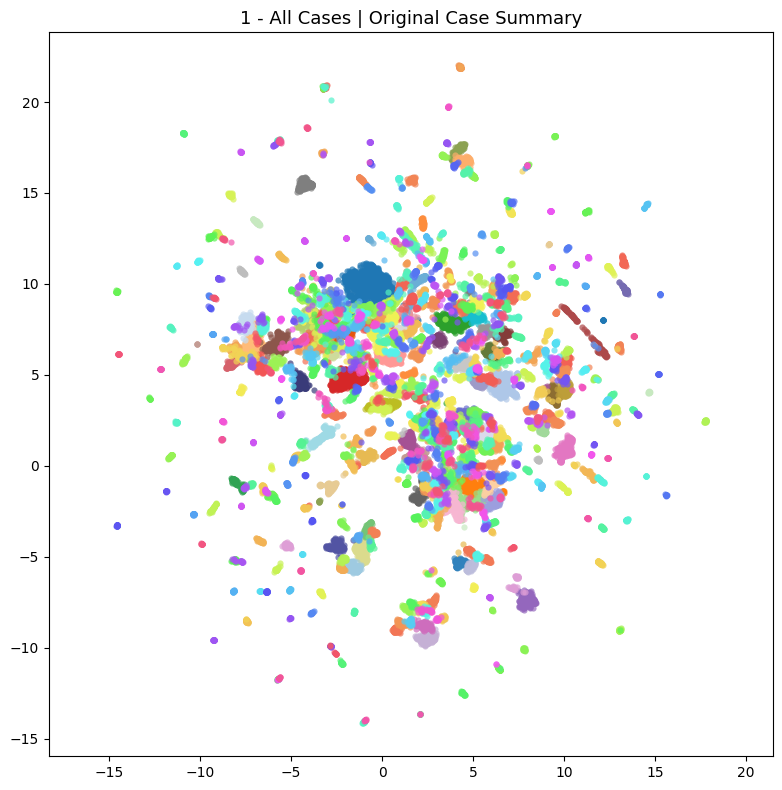


📈 visualize_barchart()


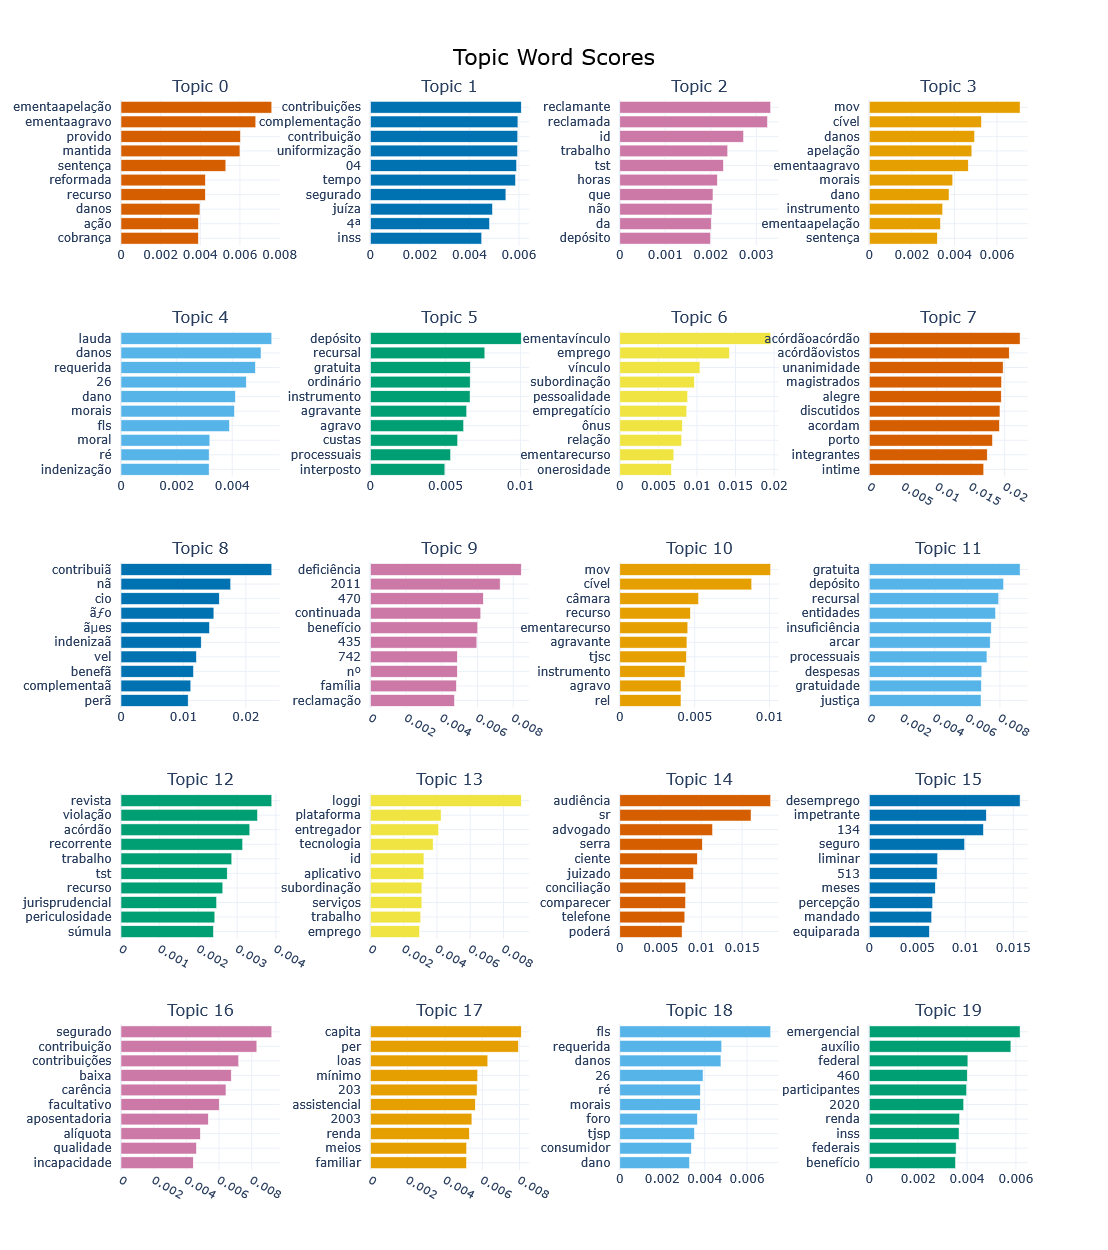


🌳 visualize_hierarchy()


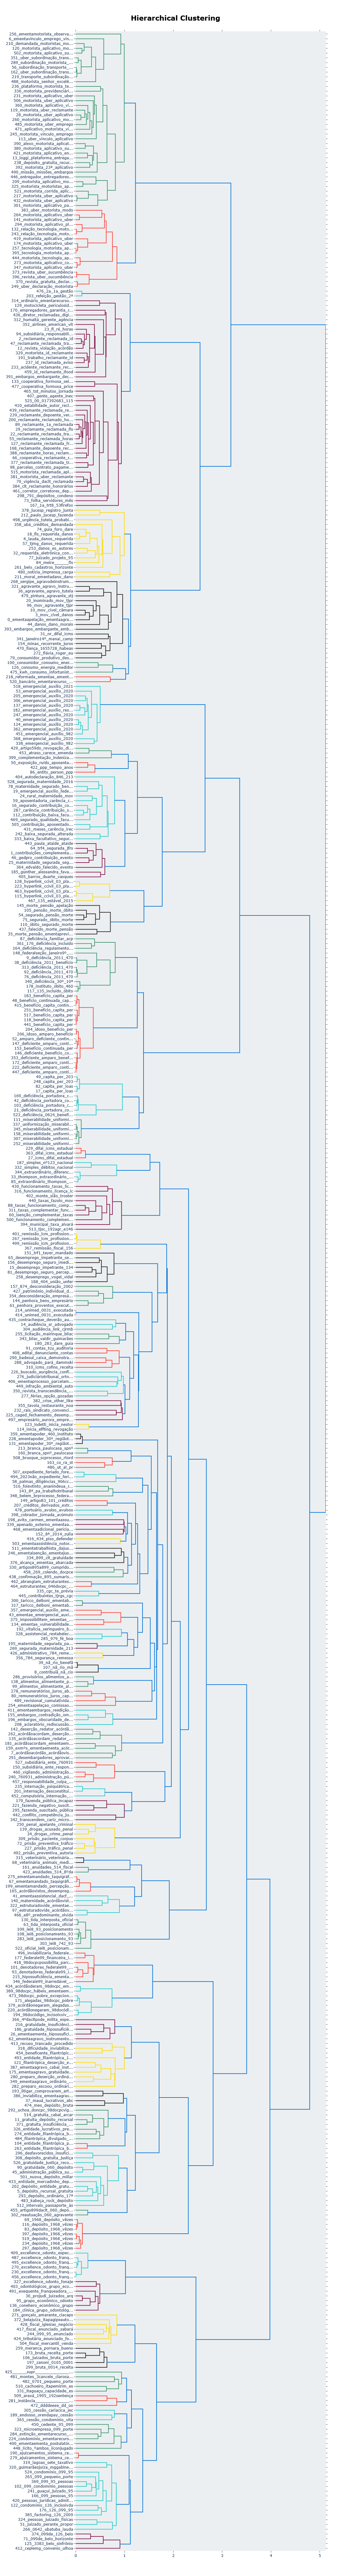


🌳 Cor por tópico


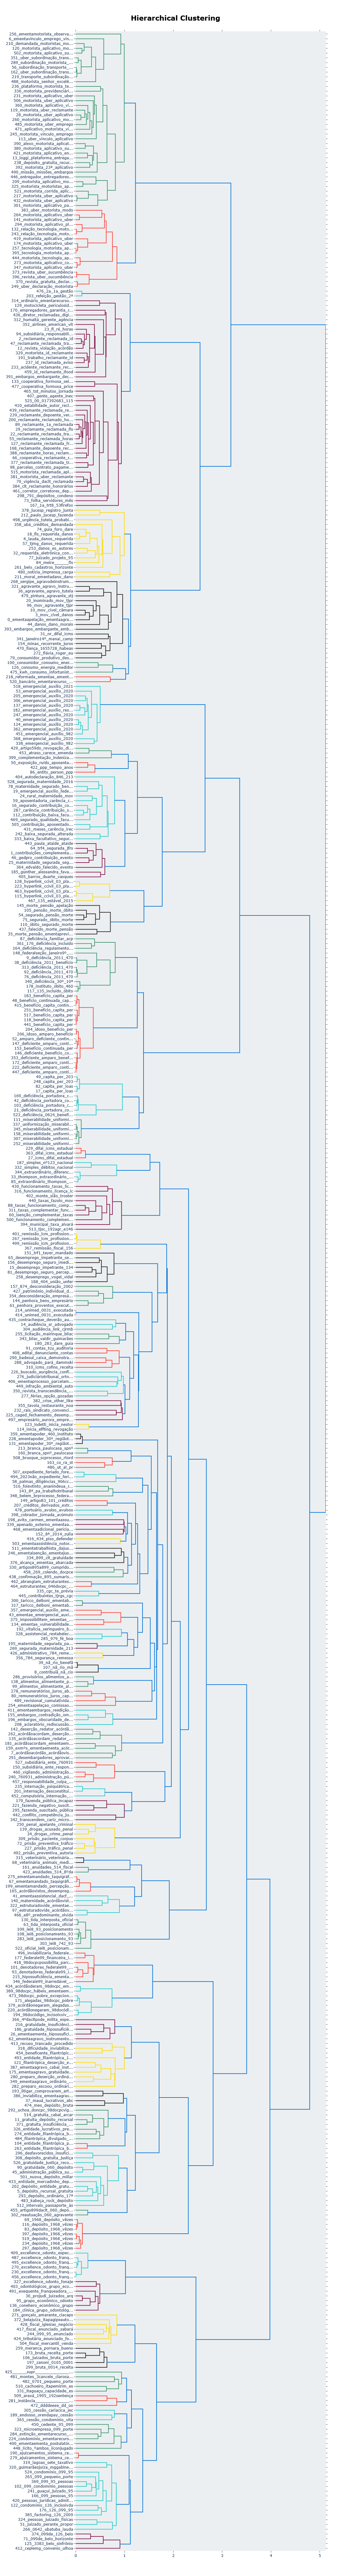

In [58]:
#EXPERIMENTO 1 -> EMENTA COMPLETA, INDEPENDENTE DO ENVOLVE MEI (56348 PROCESSOS)
titulo = "1 - All Cases | Original Case Summary"
print(f"🔎 EXPERIMENTO 1: {len(df)} registros")
res = executar_bertopic(df['ementa_completa'], 
                        df['vetor_ementa_reduzido_extracao_topico'], #dimensão 5 
                        df['vetor_ementa_reduzido_plotagem'], #dimensão 2
                        anotar_centroides=False,titulo=titulo)

🔎 EXPERIMENTO 2: 11760 registros


2025-10-20 17:20:42,535 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-20 17:20:42,542 - BERTopic - Dimensionality - Completed ✓
2025-10-20 17:20:42,555 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-20 17:20:43,631 - BERTopic - Cluster - Completed ✓
2025-10-20 17:20:43,657 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-20 17:21:09,682 - BERTopic - Representation - Completed ✓



🔢 Tópicos (sem ruído): 126
🔸 Documentos como ruído (-1): 4464
✅ Silhouette (sem ruído, no espaço de plotagem): 0.3169

📊 get_topic_info() (topo):


Topic  Count                                            Name  \
0      -1   4464                                 -1_de_que_do_da   
1       0   1092                   0_reclamante_que_de_reclamada   
2       1    330                      1_federal_04_juiz_segurado   
3       2    311                        2_danos_26_fls_requerida   
4       3    288       3_individual_provido_recurso_ementaagravo   
5       4    276                       4_mov_recurso_de_sentença   
6       5    213            5_gratuita_justiça_recursal_depósito   
7       6    170              6_federal_eletrônico_código_autora   
8       7    159  7_segurado_contribuições_contribuição_carência   
9       8    146                        8_fls_requerida_de_danos   
10      9    140             9_depósito_agravo_recursal_gratuita   
11     10    132           10_desemprego_autora_benefício_seguro   
12     11    127          11_depósito_recursal_metade_lucrativos   
13     12    109         12_agravante_agravo_instrumento_decisão   
14     13    104                       13_nã_contribuiã_ãµes_rio   
15     14     98              14_isenção_complementar_taxa_taxas   
16     15     95                 15_que_reclamada_reclamante_não   
17     16     92                  16_reclamante_reclamada_da_que   
18     17     91             17_contribuição_anos_tempo_segurado   
19     18     84         18_palmas_diligências_966ccaos_estendam   

                                       Representation  \
0        [de, que, do, da, em, se, não, no, para, ao]   
1   [reclamante, que, de, reclamada, da, trabalho,...   
2   [federal, 04, juiz, segurado, trf4, contribuiç...   
3   [danos, 26, fls, requerida, de, lauda, que, da...   
4   [individual, provido, recurso, ementaagravo, d...   
5   [mov, recurso, de, sentença, da, que, do, cíve...   
6   [gratuita, justiça, recursal, depósito, arcar,...   
7   [federal, eletrônico, código, autora, seguro, ...   
8   [segurado, contribuições, contribuição, carênc...   
9   [fls, requerida, de, danos, que, ré, em, não, ...   
10  [depósito, agravo, recursal, gratuita, ordinár...   
11  [desemprego, autora, benefício, seguro, lei, f...   
12  [depósito, recursal, metade, lucrativos, domés...   
13  [agravante, agravo, instrumento, decisão, just...   
14  [nã, contribuiã, ãµes, rio, cio, vel, benefã, ...   
15  [isenção, complementar, taxa, taxas, funcionam...   
16  [que, reclamada, reclamante, não, da, do, de, ...   
17  [reclamante, reclamada, da, que, na, em, de, d...   
18  [contribuição, anos, tempo, segurado, aposenta...   
19  [palmas, diligências, 966ccaos, estendam, regi...   

                                  Representative_Docs  
0   [Inteiro TeorPROCESSO nº0101390-78.2019.5.01.0...  
1   [PODER JUDICIÁRIOJUSTIÇA DO TRABALHOTRIBUNAL R...  
2   [Inteiro TeorPoder JudiciárioJUSTIÇA FEDERALSe...  
3   [SENTENÇAProcesso nº:1002274-57.2022.8.26.0483...  
4   [Ementa"AGRAVO DE INSTRUMENTO -ASSISTÊNCIA JUD...  
5   [EmentaAPELAÇÃO CÍVEL.AÇÃO DE BUSCA E APREENSÃ...  
6   [Inteiro TeorPODER JUDICIÁRIOJUSTIÇA DO TRABAL...  
7   [Inteiro TeorRECURSO CÍVEL Nº 5014158-78.2014....  
8   [Inteiro TeorJUSTIÇA FEDERAL DA 5ª REGIÃOProce...  
9   [TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO CO...  
10  [Inteiro TeorPODER JUDICIÁRIOJUSTIÇA DO TRABAL...  
11  [Inteiro TeorTERMO Nr: 9301073644/2018PROCESSO...  
12  [Inteiro TeorCONCLUSÃONesta data, faço os pres...  
13  [Inteiro TeorProcesso:4010057-10.2016.8.24.000...  
14  [Inteiro TeorPoder JudiciÃ¡rio JUSTIÃ‡A FEDERA...  
15  [EmentaAPELAÇÃO CÍVEL.TRIBUTÁRIO.EXECUÇÃO FISC...  
16  [Inteiro TeorPODER JUDICIÁRIOJUSTIÇA DO TRABAL...  
17  [Poder JudiciárioJustiça do TrabalhoTribunal R...  
18  [NÚMERO ÚNICO:5000564-15.2024.4.03.6342POLO AT...  
19  [PODER JUDICIÁRIOJUSTIÇA DO TRABALHOTRIBUNAL R...


🗂️ Tópicos (palavras mais representativas):
  • Tópico   0 (Count=1092): reclamante, que, de, reclamada, da, trabalho, do, em, na, não
  • Tópico   1 (Count=330): federal, 04, juiz, segurado, trf4, contribuições, do, evento, de, inss
  • Tópico   2 (Count=311): danos, 26, fls, requerida, de, lauda, que, dano, em, morais
  • Tópico   3 (Count=288): individual, provido, recurso, ementaagravo, de, microempreendedor, ementaapelação, agravante, mantida, sentença
  • Tópico   4 (Count=276): mov, recurso, de, sentença, da, que, do, cível, individual, danos
  • Tópico   5 (Count=213): gratuita, justiça, recursal, depósito, arcar, processuais, insuficiência, despesas, concessão, pessoa
  • Tópico   6 (Count=170): federal, eletrônico, código, autora, seguro, desemprego, benefício, do, verifica, de
  • Tópico   7 (Count=159): segurado, contribuições, contribuição, carência, aposentadoria, de, incapacidade, do, benefício, da
  • Tópico   8 (Count=146): fls, requerida, de, danos, que, ré, em, não,

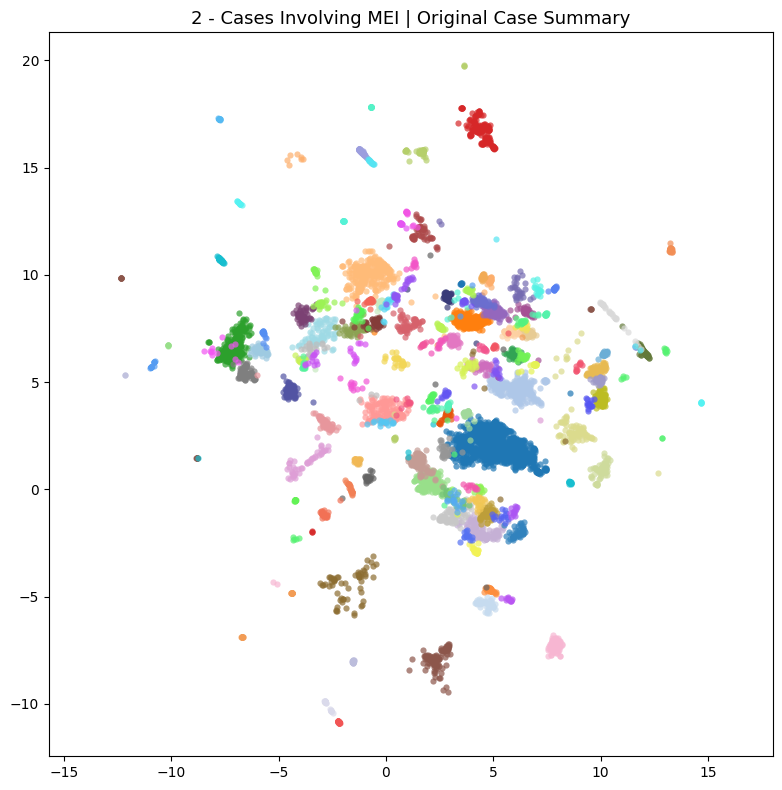


📈 visualize_barchart()


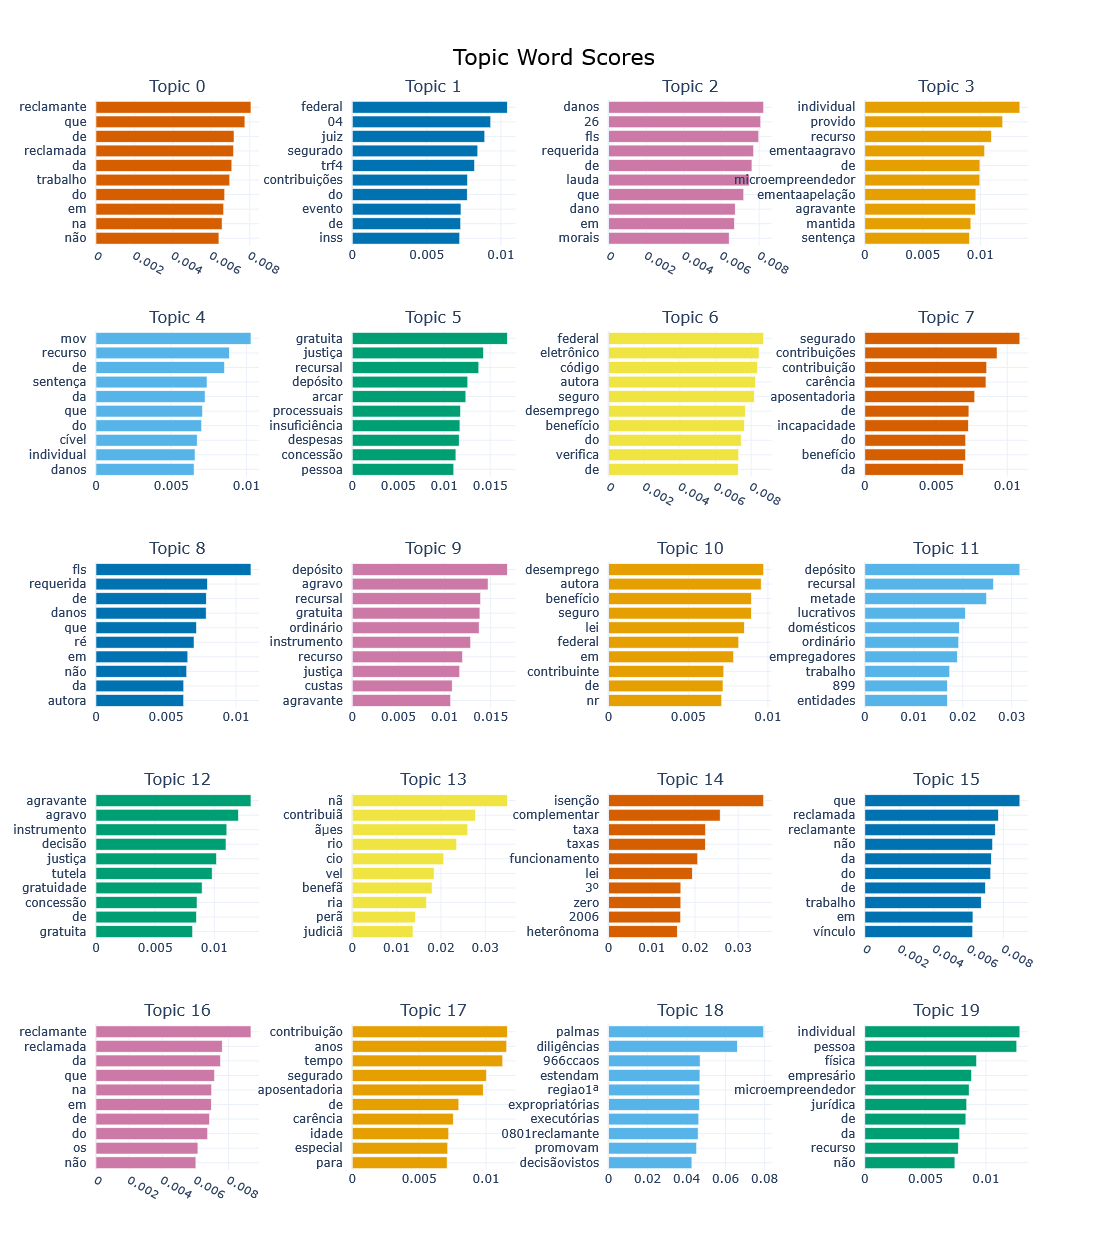


🌳 visualize_hierarchy()


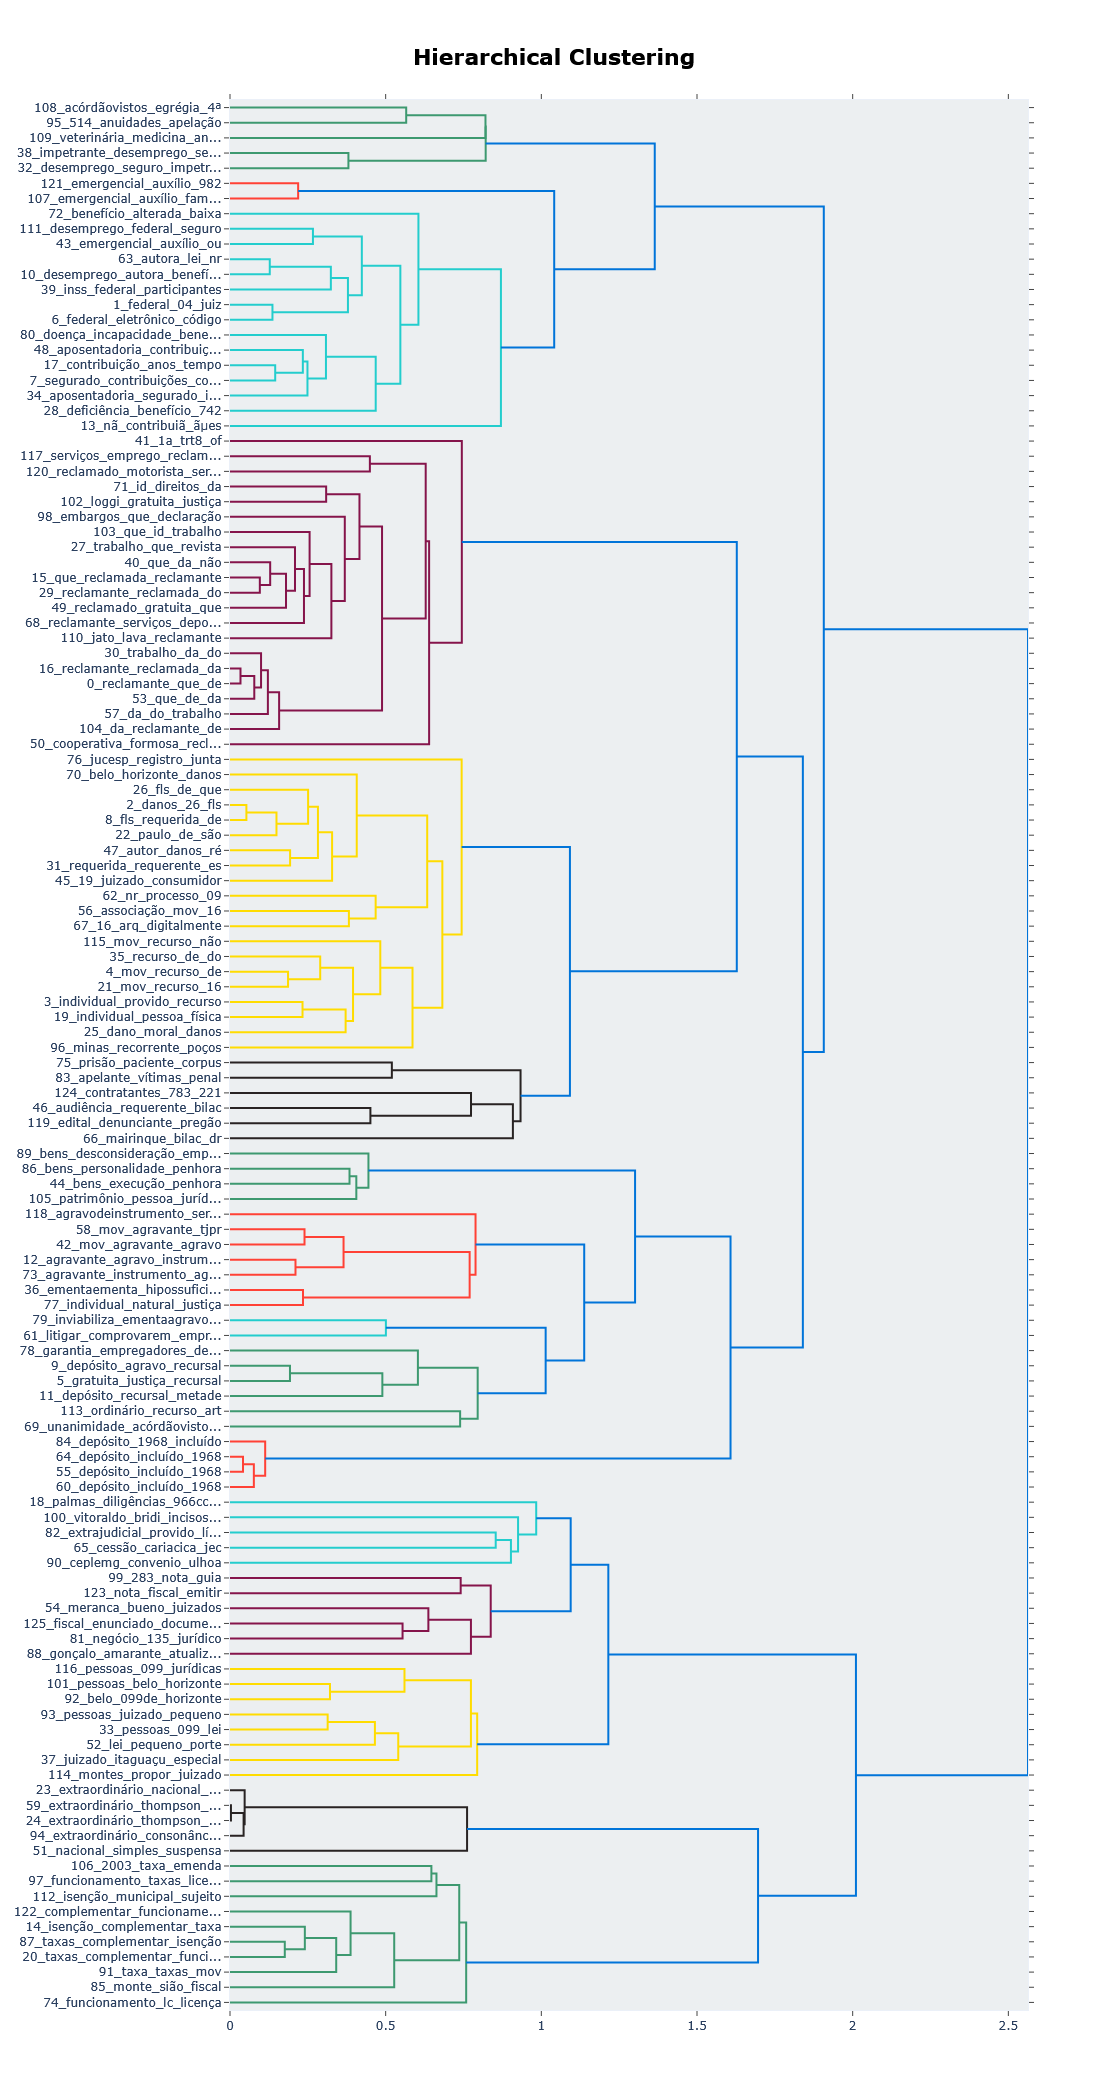


🌳 Cor por tópico


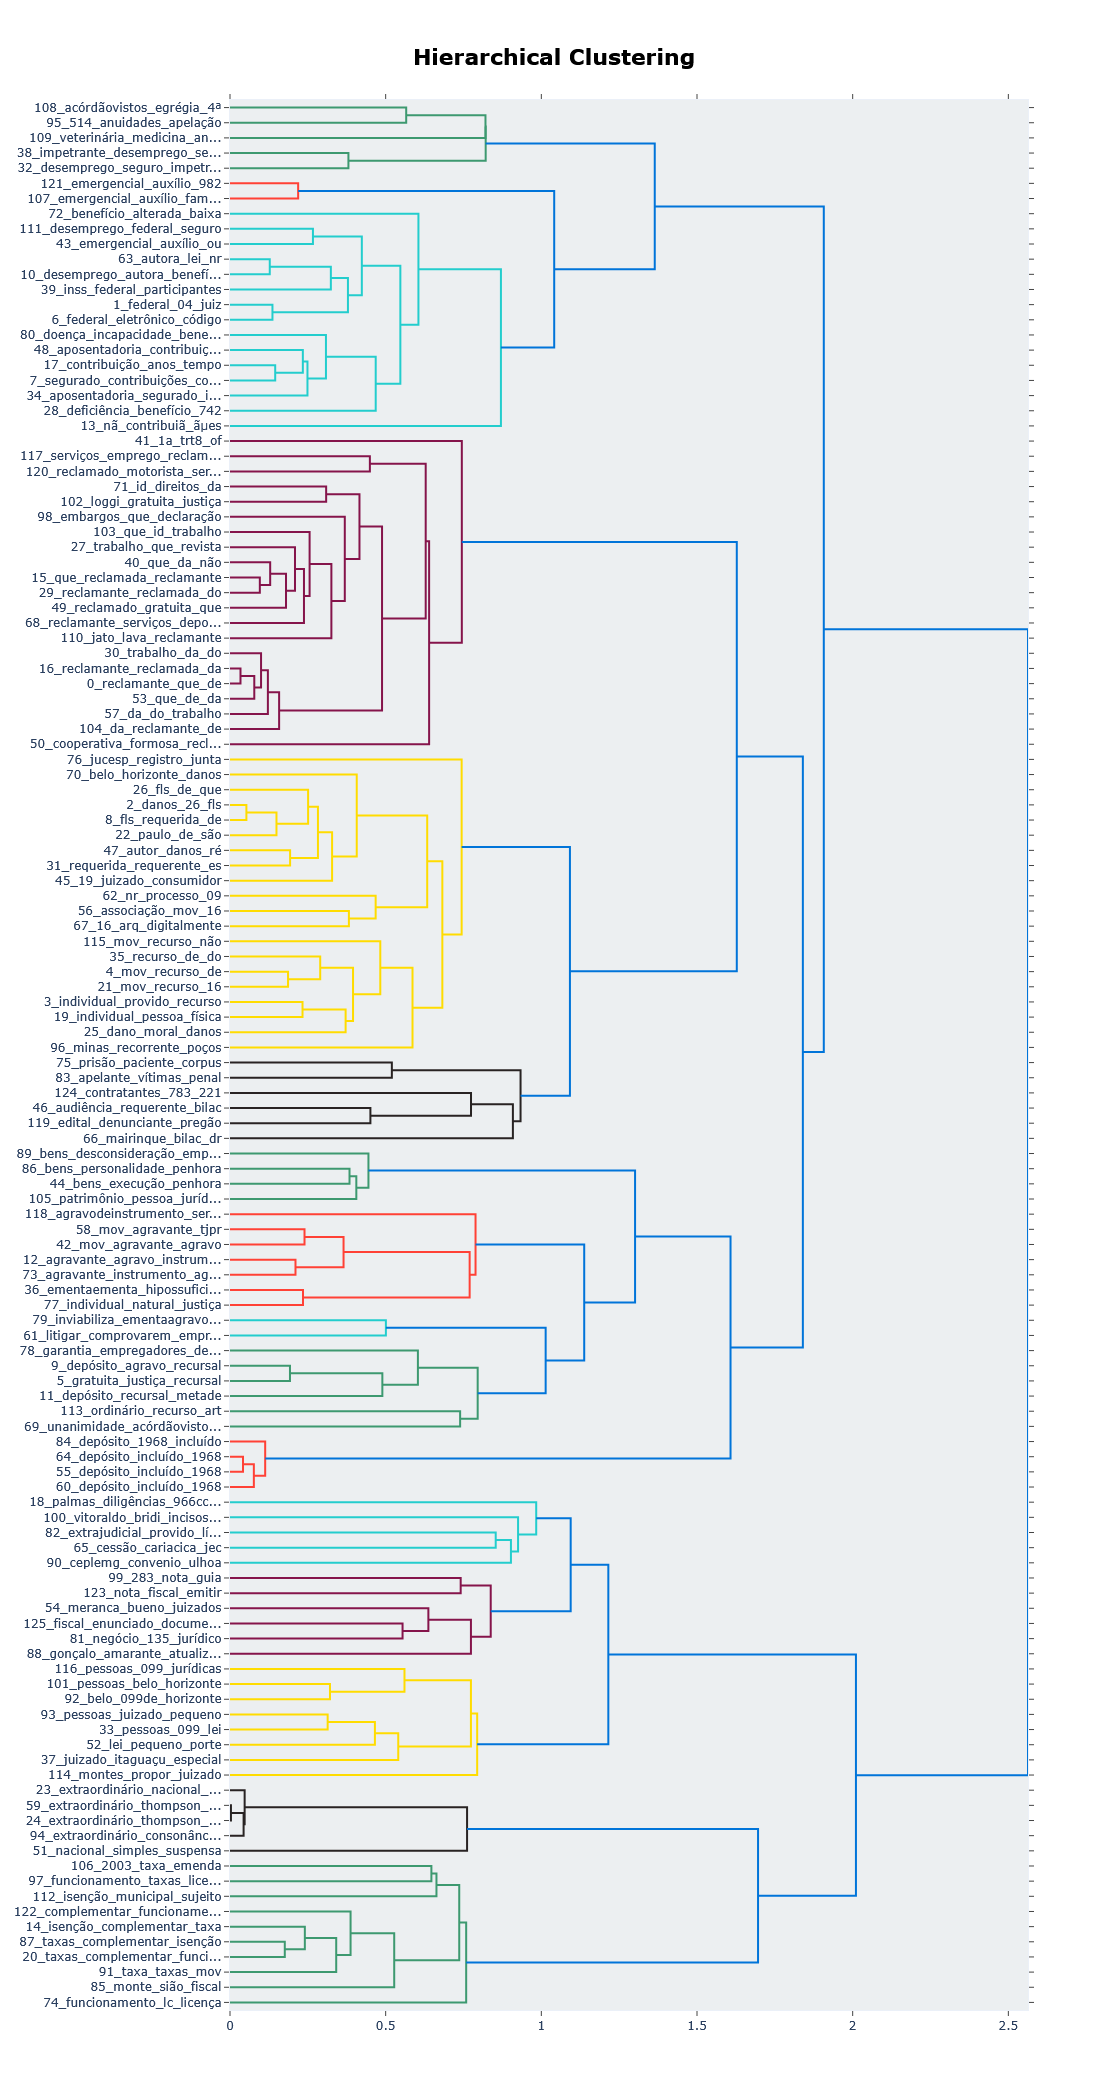

In [12]:
#EXPERIMENTO 2 -> EMENTA COMPLETA, ENVOLVE MEI = SIM (11775  PROCESSOS)
titulo = "2 - Cases Involving MEI | Original Case Summary"
exp2 = df[df["envolve_mei"].isin(["Sim", "SIM", 1, True])].copy()
print(f"🔎 EXPERIMENTO 2: {len(exp2)} registros")
res = executar_bertopic(exp2['ementa_completa'], 
                        exp2['vetor_ementa_reduzido_extracao_topico'],
                        exp2['vetor_ementa_reduzido_plotagem'], 
                        anotar_centroides=True,titulo=titulo)

2025-10-20 17:21:26,659 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-20 17:21:26,660 - BERTopic - Dimensionality - Completed ✓
2025-10-20 17:21:26,662 - BERTopic - Cluster - Start clustering the reduced embeddings


🔎 EXPERIMENTO 4: 11760 registros


2025-10-20 17:21:27,298 - BERTopic - Cluster - Completed ✓
2025-10-20 17:21:27,305 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-20 17:21:28,477 - BERTopic - Representation - Completed ✓



🔢 Tópicos (sem ruído): 58
🔸 Documentos como ruído (-1): 3848
✅ Silhouette (sem ruído, no espaço de plotagem): 0.4607

📊 get_topic_info() (topo):


Topic  Count                                               Name  \
0      -1   3848                                    -1_de_foi_se_do   
1       0   2531          0_trabalhador_vínculo_verbas_empregatício   
2       1    999     1_justiça_gratuita_hipossuficiência_financeira   
3       2    457                      2_taxas_complementar_taxa_lei   
4       3    363                  3_jucesp_registro_junta_comercial   
5       4    334                   4_nacional_simples_regime_adesão   
6       5    275                    5_desemprego_seguro_renda_união   
7       6    233                       6_conta_danos_morais_valores   
8       7    206      7_personalidade_jurídica_desconsideração_bens   
9       8    203                            8_nome_danos_morais_seu   
10      9    179             9_incapacidade_doença_auxílio_segurado   
11     10    166  10_tempo_aposentadoria_contribuição_contribuições   
12     11    152               11_sindicato_rais_coletiva_sindicais   
13     12    133             12_licitação_edital_licitatório_pregão   
14     13    108              13_recurso_interposto_ordinário_parte   
15     14     99              14_juros_capitalização_banco_comissão   
16     15     93                15_depósito_recursal_metade_redução   
17     16     91              16_maternidade_salário_inss_benefício   
18     17     81              17_emergencial_auxílio_familiar_união   
19     18     73      18_deficiência_assistencial_benefício_família   

                                       Representation  \
0      [de, foi, se, do, uma, da, que, para, um, mei]   
1   [trabalhador, vínculo, verbas, empregatício, e...   
2   [justiça, gratuita, hipossuficiência, financei...   
3   [taxas, complementar, taxa, lei, isenção, muni...   
4   [jucesp, registro, junta, comercial, estado, f...   
5   [nacional, simples, regime, adesão, tributário...   
6   [desemprego, seguro, renda, união, própria, be...   
7   [conta, danos, morais, valores, banco, indeniz...   
8   [personalidade, jurídica, desconsideração, ben...   
9   [nome, danos, morais, seu, indenização, inadim...   
10  [incapacidade, doença, auxílio, segurado, bene...   
11  [tempo, aposentadoria, contribuição, contribui...   
12  [sindicato, rais, coletiva, sindicais, emprega...   
13  [licitação, edital, licitatório, pregão, certa...   
14  [recurso, interposto, ordinário, parte, depósi...   
15  [juros, capitalização, banco, comissão, fgo, b...   
16  [depósito, recursal, metade, redução, valor, 8...   
17  [maternidade, salário, inss, benefício, mulher...   
18  [emergencial, auxílio, familiar, união, recebe...   
19  [deficiência, assistencial, benefício, família...   

                                  Representative_Docs  
0   [Uma microempresa entrou com um agravo interno...  
1   [Um trabalhador entrou com uma reclamação cont...  
2   [Um microempreendedor individual (MEI) entrou ...  
3   [O município de Guarapuava interpôs um recurso...  
4   [Um indivíduo ajuizou uma ação declaratória de...  
5   [O caso envolve um recurso extraordinário inte...  
6   [A União recorreu contra uma sentença que julg...  
7   [Um microempreendedor individual do ramo de ve...  
8   [Um empresário individual, que é um MEI, teve ...  
9   [Um profissional autônomo ajuizou uma ação con...  
10  [Uma pessoa entrou com uma ação contra o Insti...  
11  [O autor, um MEI, entrou com um recurso contra...  
12  [Um sindicato entrou com uma ação contra um re...  
13  [A Prefeitura Municipal de Desterro do Melo pu...  
14  [Trata-se de um processo em que a parte reclam...  
15  [Um MEI ajuizou uma ação revisional contra um ...  
16  [Uma empresa de pequeno porte entrou com um re...  
17  [Uma mulher, que trabalha como costureira e é ...  
18  [Uma pessoa entrou com um recurso contra uma s...  
19  [Uma pessoa entrou com um recurso contra uma d...


🗂️ Tópicos (palavras mais representativas):
  • Tópico   0 (Count=2531): trabalhador, vínculo, verbas, empregatício, emprego, trabalho, rescisórias, de, como, que
  • Tópico   1 (Count=999): justiça, gratuita, hipossuficiência, financeira, gratuidade, mei, custas, processuais, arcar, concessão
  • Tópico   2 (Count=457): taxas, complementar, taxa, lei, isenção, município, funcionamento, 123, 2006, cobrança
  • Tópico   3 (Count=363): jucesp, registro, junta, comercial, estado, fraude, união, paulo, danos, morais
  • Tópico   4 (Count=334): nacional, simples, regime, adesão, tributário, débitos, microempresas, pequeno, porte, fiscais
  • Tópico   5 (Count=275): desemprego, seguro, renda, união, própria, benefício, suficiente, contribuinte, sócio, como
  • Tópico   6 (Count=233): conta, danos, morais, valores, banco, indenização, consumidor, por, mei, do
  • Tópico   7 (Count=206): personalidade, jurídica, desconsideração, bens, patrimônio, execução, da, empresário, empresa, individual


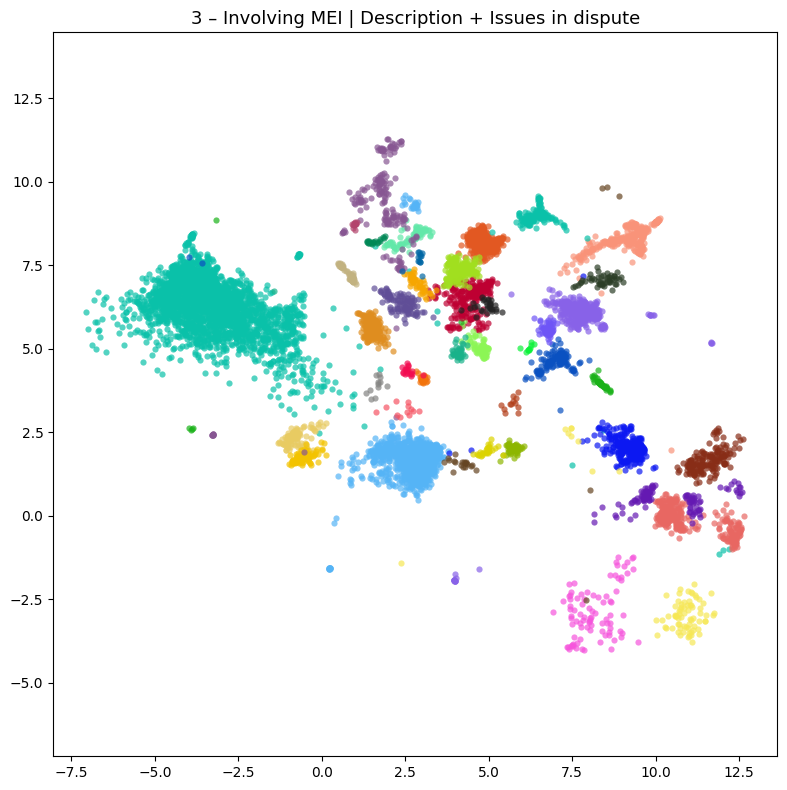


📈 visualize_barchart()


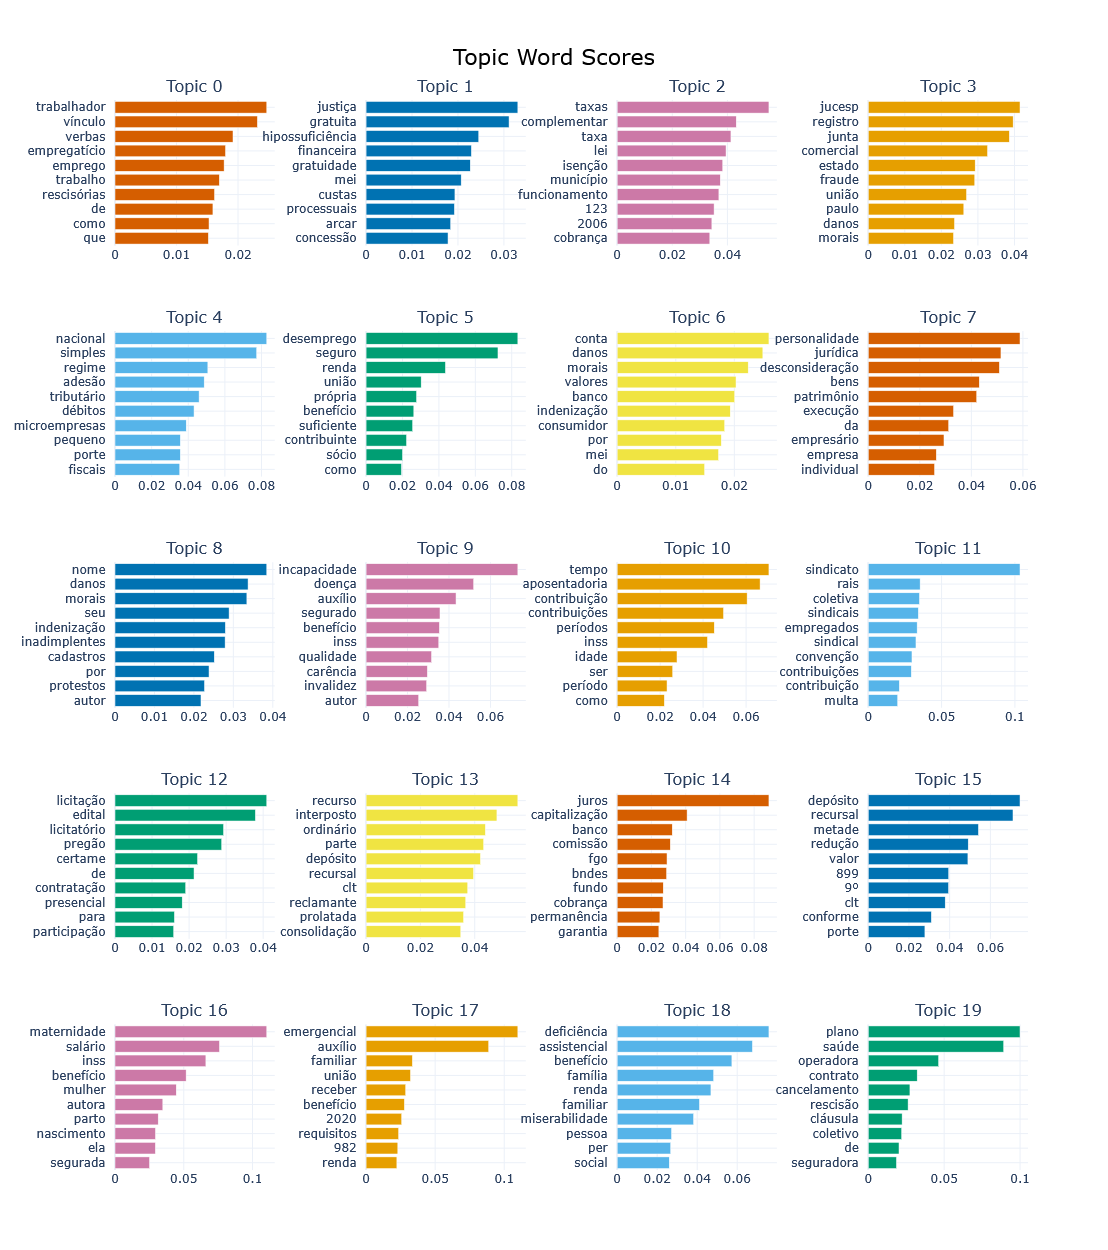


🌳 visualize_hierarchy()


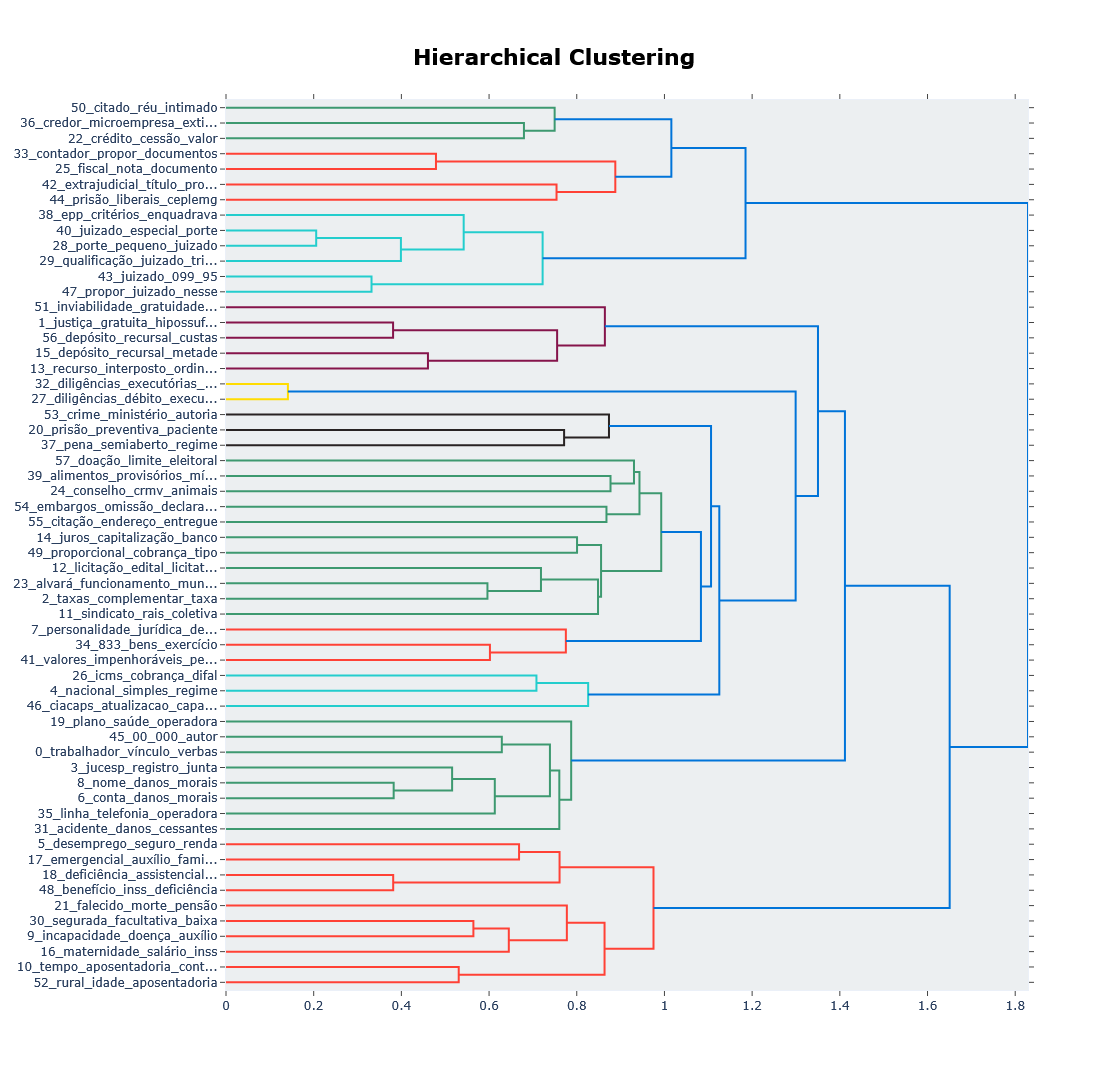


🌳 Cor por tópico


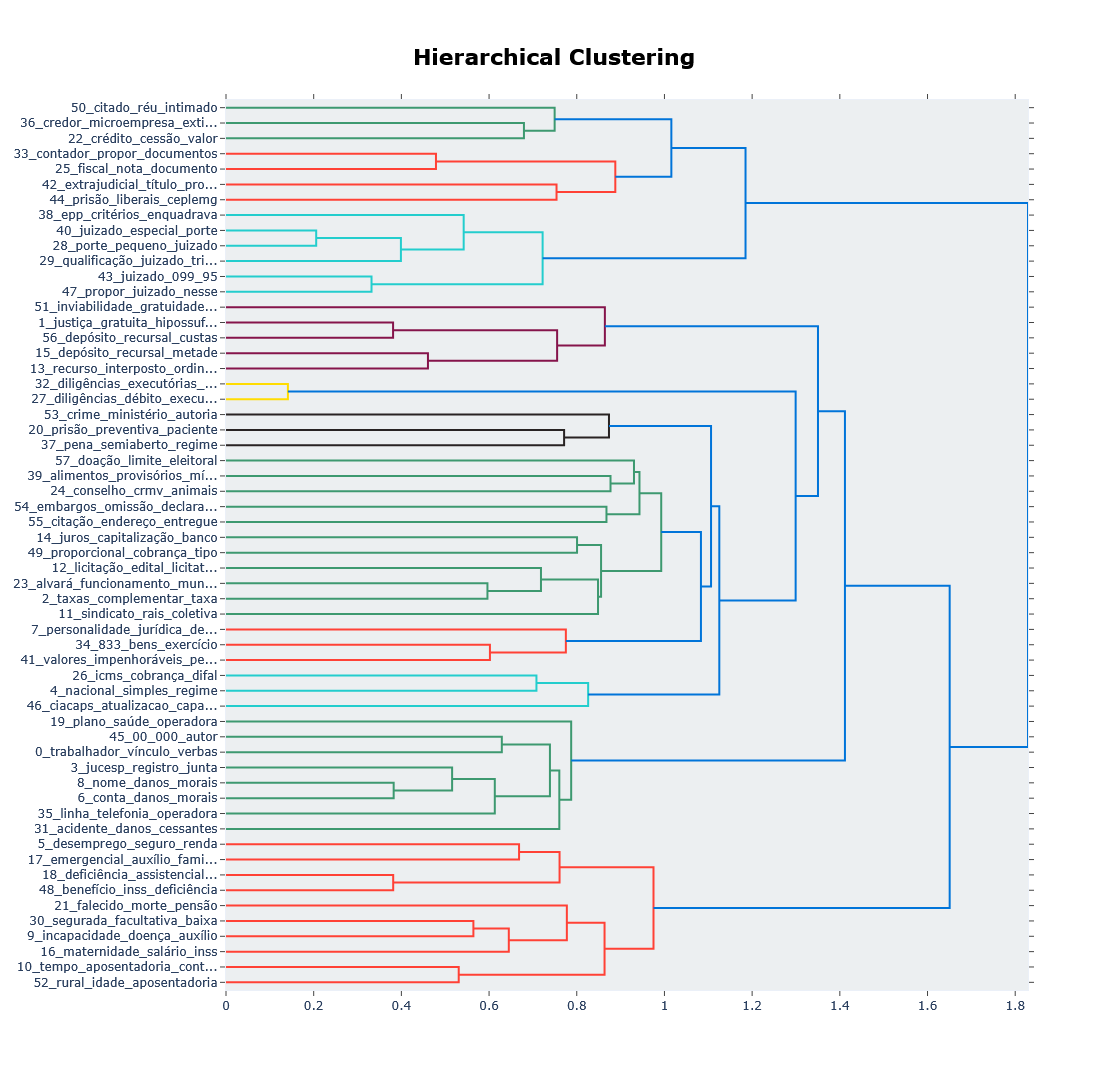

In [13]:
#EXPERIMENTO 3 -> RESUMO + QUESTOES, ENVOLVE MEI = SIm
titulo = "3 – Involving MEI | Description + Issues in dispute"
exp4 = df.loc[df["texto_descricao_caso"].fillna("").str.strip().ne("")].copy()
exp4 = exp4[exp4["envolve_mei"].isin(["Sim", "SIM", 1, True])].copy()
print(f"🔎 EXPERIMENTO 4: {len(exp4)} registros")
res = executar_bertopic(exp4['texto_descricao_caso'], 
                        exp4['vetor_descricao_questoes_testes_extracao'],
                        exp4['vetor_descricao_questoes_teste_plotagem'], 
                        cor_por_processo=exp4["cor_cluster"],
                        anotar_centroides=True, titulo = titulo)


In [5]:
# conexão
conn = psycopg2.connect(
    host="localhost",
    database="PROCESSOS",
    user="postgres",
    password="admin",
)

def plot_cluster_banco(titulo="", show_noise=False, point_size=20, alpha=0.7):
    cur = conn.cursor()
    # query (inclui cor_cluster e descricao_topico_llm)
    cur.execute("""
        SELECT 
            vetor_descricao_questoes_teste_plotagem AS coordenadas_umap,
            COALESCE(NULLIF(numero_topico_llm, '')::int, -1) AS numero_topico_llm,
            cor_cluster,
            descricao_topico_llm
        FROM processos
        WHERE (descricao_topico_llm IS NOT NULL
           OR descricao_topico_BERTopic_Padrao = 'Tópico indefinido') AND not (
    CAST(split_part(trim(both '[]' from vetor_descricao_questoes_teste_plotagem::text), ',', 1) AS float) > 7
    AND CAST(split_part(trim(both '[]' from vetor_descricao_questoes_teste_plotagem::text), ',', 2) AS float) > 18
) 
    """)
    rows = cur.fetchall()
    cur.close()
    conn.close()

    # parser simples: string -> lista de floats
    def parse_vec(s):
        try:
            return json.loads(s)  # "[1.2, 3.4]"
        except Exception:
            s = str(s).strip("[](){}")
            return [float(x) for x in s.split(",") if x.strip()]

    # extrai colunas
    coords = []
    labels = []
    cores_proc = []
    descs_proc = []
    for c, lbl, cor, desc in rows:
        coords.append(parse_vec(c))
        labels.append(int(lbl))
        cores_proc.append((cor or "").strip() if cor is not None else None)
        d = None if desc is None or str(desc).strip() == "" else str(desc)
        descs_proc.append(d)

    Xp = np.array(coords, dtype=np.float32)
    y  = np.array(labels, dtype=np.int32)

    print(f"N amostras: {len(y)} | D = {Xp.shape[1]} | clusters (incl. -1) = {len(np.unique(y))}")

    # Silhouette geral
    if len(np.unique(y)) >= 2 and len(y) > 2:
        try:
            sil_all = silhouette_score(Xp[:, :2], y, metric="euclidean")
            print(f"Silhouette (todos): {sil_all:.4f}")
        except Exception as e:
            print(f"Silhouette (todos) não calculada: {e}")
    else:
        print("Silhouette (todos): clusters insuficientes.")

    # Silhouette sem ruído
    mask_nn = (y != -1)
    if mask_nn.sum() > 2 and len(np.unique(y[mask_nn])) >= 2:
        try:
            sil_nn = silhouette_score(Xp[mask_nn, :2], y[mask_nn], metric="euclidean")
            print(f"Silhouette (sem ruído -1): {sil_nn:.4f}")
        except Exception as e:
            print(f"Silhouette (sem ruído) não calculada: {e}")
    else:
        print("Silhouette (sem ruído): clusters insuficientes.")

    # ---------- Paleta ampla ----------
    def topic_colors_palette(n_needed: int):
        cmaps = [mpl.cm.get_cmap('tab20'), mpl.cm.get_cmap('tab20b'), mpl.cm.get_cmap('tab20c')]
        paleta = []
        for cmap in cmaps:
            paleta.extend([mpl.colors.to_hex(cmap(i)) for i in range(cmap.N)])
        if n_needed > len(paleta):
            extra = n_needed - len(paleta)
            hsv_extra = [mpl.colors.hsv_to_rgb((h, 0.65, 0.95)) for h in np.linspace(0, 1, extra, endpoint=False)]
            paleta.extend([mpl.colors.to_hex(c) for c in hsv_extra])
        return paleta

    topicos_validos = [t for t in np.unique(y) if t != -1]
    palette_all = topic_colors_palette(len(topicos_validos))

    # ---------- Cores por tópico (majoritária), com regra da descrição nula ----------
    used_colors = {c for c in cores_proc if c}
    assigned_new = set()

    def pick_new_unused_color():
        for c in palette_all:
            if c not in used_colors and c not in assigned_new:
                assigned_new.add(c)
                return c
        # fallback via HSV
        for h in np.linspace(0, 1, 360, endpoint=False):
            c = mpl.colors.to_hex(mpl.colors.hsv_to_rgb((h, 0.70, 0.95)))
            if c not in used_colors and c not in assigned_new:
                assigned_new.add(c)
                return c
        return "#808080"

    # dataframe mínimo em listas
    topic_color_major = {}
    for t in topicos_validos:
        idx = (y == t)
        cores_t = [cores_proc[i] for i in np.where(idx)[0] if cores_proc[i]]
        descs_t = [descs_proc[i] for i in np.where(idx)[0]]

        # cor majoritária (se houver cores)
        if cores_t:
            topic_color_major[t] = Counter(cores_t).most_common(1)[0][0]

        # maioria com desc nula/vazia?
        total = len(descs_t)
        null_desc = sum(1 for d in descs_t if d is None or str(d).strip() == "")
        if total > 0 and null_desc > total / 2:
            topic_color_major[t] = pick_new_unused_color()

    # fallback: se algum tópico ficou sem cor definida, pegue da paleta (posição ordenada)
    # usa ordenação por frequência para estabilidade
    freq = Counter(y[y != -1])
    ordered_topics = [t for t, _ in freq.most_common()]
    for i, t in enumerate(ordered_topics):
        topic_color_major.setdefault(t, palette_all[i % len(palette_all)])

    # ---------- Plot no estilo "bolhas" (sem halo/centróide/legenda) ----------
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_box_aspect(1)

    # ruído (opcional)
    if show_noise and (y == -1).any():
        m = (y == -1)
        ax.scatter(Xp[m, 0], Xp[m, 1], s=point_size, alpha=0.25, c="#BFBFBF", linewidths=0, zorder=1)

    # clusters coloridos
    for t in ordered_topics:
        m = (y == t)
        if np.any(m):
            cor = topic_color_major.get(t, "#BFBFBF")
            ax.scatter(Xp[m, 0], Xp[m, 1], s=point_size, alpha=alpha, c=cor, linewidths=0, zorder=2)

    ttl = titulo or "Tópicos (Gráfico de bolhas)"
    ax.set_title(ttl, fontsize=13)
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.grid(False)
    ax.set_aspect('equal', adjustable='datalim')
    plt.tight_layout()
    plt.show()

    # retorno opcional útil (para salvar/inspecionar cores)
    return {
        "silhouette_all": float(sil_all) if 'sil_all' in locals() and sil_all is not None else None,
        "silhouette_no_noise": float(sil_nn) if 'sil_nn' in locals() and sil_nn is not None else None,
        "cor_por_topico": topic_color_major,
        "topicos_ordenados": ordered_topics
    }


N amostras: 11760 | D = 2 | clusters (incl. -1) = 55
Silhouette (todos): -0.0099
Silhouette (sem ruído -1): 0.3933


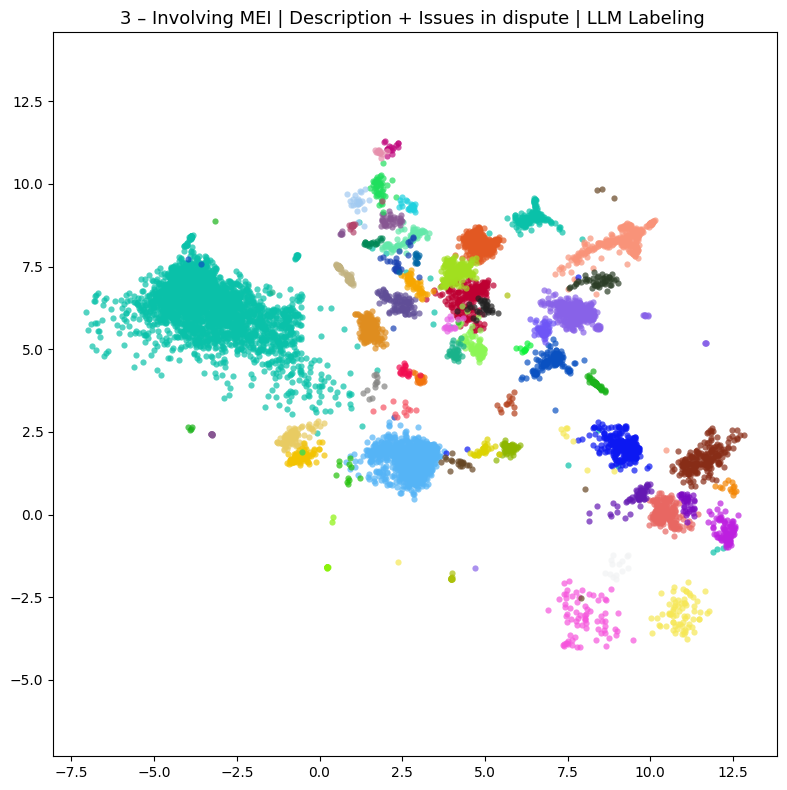

{'silhouette_all': -0.009930591098964214,
 'silhouette_no_noise': 0.39330530166625977,
 'cor_por_topico': {0: '#E862E4',
  1: '#55B4F6',
  2: '#0CF239',
  3: '#0067A5',
  4: '#F65564',
  5: '#E25822',
  6: '#DF8D1F',
  7: '#0AC1A9',
  8: '#23C10A',
  9: '#F2730C',
  10: '#0A51C1',
  11: '#1941B2',
  12: '#8862E8',
  13: '#1FDF5D',
  14: '#F3C300',
  15: '#1FD1DF',
  16: '#A1CAF1',
  17: '#E68FAC',
  18: '#62E8A9',
  19: '#C10A7E',
  20: '#8DB600',
  21: '#6E55F6',
  22: '#B3446C',
  23: '#BE0032',
  24: '#222222',
  25: '#8BF20C',
  26: '#882D17',
  27: '#A1DF1F',
  28: '#6419B2',
  29: '#7B0AC1',
  30: '#8CF655',
  31: '#E8CB62',
  32: '#654522',
  33: '#BD1FDF',
  34: '#0C18F2',
  35: '#DCD300',
  36: '#1AB219',
  37: '#E86762',
  38: '#F6A600',
  39: '#F99379',
  40: '#19B28A',
  41: '#2B3D26',
  42: '#F20C51',
  43: '#875692',
  44: '#F38400',
  45: '#F2F3F4',
  46: '#F655DC',
  47: '#ACC10A',
  48: '#F6E755',
  49: '#B23E19',
  50: '#604E97',
  51: '#C2B280',
  52: '#008856',
  53

In [6]:
#EXPERIMENTO 3 -> RESUMO + QUESTOES, ENVOLVE MEI = SIM, LLM ALTERADO
titulo = "3,5 – Involving MEI | Description + Issues in dispute | LLM Labeling "
plot_cluster_banco(titulo = titulo)

N amostras: 11760 | D = 2 | clusters (incl. -1) = 41
Silhouette (todos): -0.0252
Silhouette (sem ruído -1): 0.3490


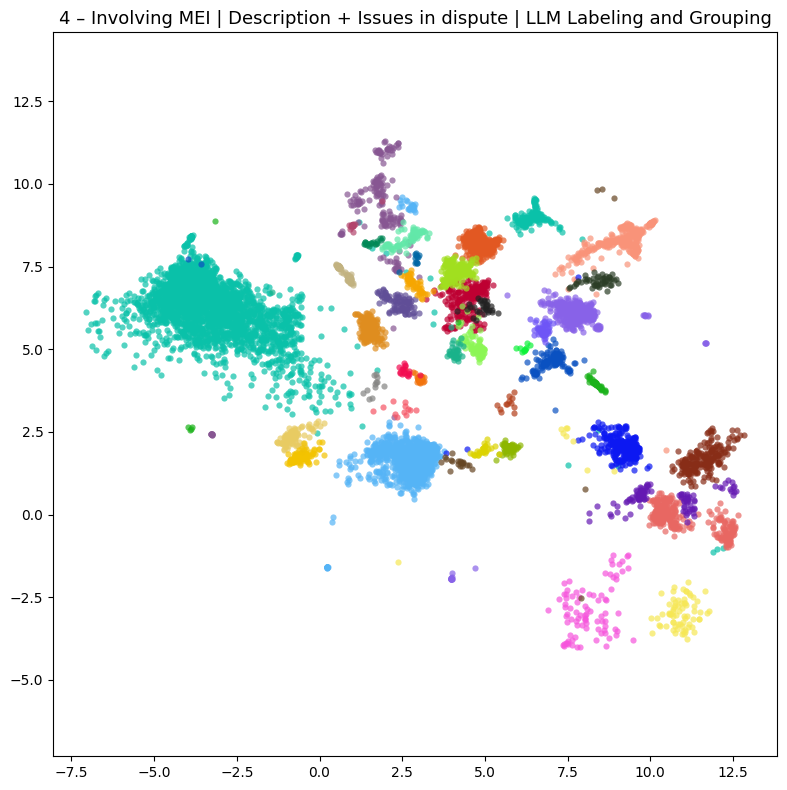

{'silhouette_all': -0.025182295590639114,
 'silhouette_no_noise': 0.34896886348724365,
 'cor_por_topico': {1: '#55B4F6',
  2: '#0CF239',
  3: '#0067A5',
  4: '#F65564',
  5: '#E25822',
  6: '#DF8D1F',
  7: '#0AC1A9',
  9: '#F2730C',
  10: '#0A51C1',
  12: '#8862E8',
  14: '#F3C300',
  18: '#62E8A9',
  20: '#8DB600',
  21: '#6E55F6',
  22: '#B3446C',
  23: '#BE0032',
  24: '#222222',
  26: '#882D17',
  27: '#A1DF1F',
  28: '#6419B2',
  30: '#8CF655',
  31: '#E8CB62',
  32: '#654522',
  34: '#0C18F2',
  35: '#DCD300',
  36: '#1AB219',
  37: '#E86762',
  38: '#F6A600',
  39: '#F99379',
  40: '#19B28A',
  41: '#2B3D26',
  42: '#F20C51',
  43: '#875692',
  46: '#F655DC',
  48: '#F6E755',
  49: '#B23E19',
  50: '#604E97',
  51: '#C2B280',
  52: '#008856',
  53: '#848482'},
 'topicos_ordenados': [7,
  1,
  12,
  5,
  39,
  34,
  37,
  23,
  6,
  27,
  26,
  43,
  10,
  31,
  28,
  14,
  46,
  50,
  18,
  48,
  51,
  30,
  20,
  38,
  21,
  36,
  41,
  40,
  24,
  9,
  35,
  32,
  42,
  22,
  

In [14]:
#EXPERIMENTO 5 -> RESUMO + QUESTOES, ENVOLVE MEI = SIM, LLM ALTERADO
titulo = "4 – Involving MEI | Description + Issues in dispute | LLM Labeling and Grouping"
plot_cluster_banco(titulo = titulo)